In [1]:
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from food_analyzer import *

In [3]:
saved_dataset = True
df_final = downloader(saved_dataset)
df_final

🌍 Lancement de la collecte
🤖 Utilisation du dataset 
--------------------------------------------------
🚀 DATASET FINAL : 2263 produits.
--------------------------------------------------
Répartition par Catégorie :
Category_Label
Céréales         297
Légumes          290
Légumineuses     289
Pizzas           286
Biscuits         282
Chocolats        278
Jus de Fruits    274
Fromages         267
Name: count, dtype: int64

Répartition par Nutriscore :
Nutriscore
A    460
B    259
C    604
D    486
E    454
Name: count, dtype: int64


,Nom,Marque,Nutriscore,Category_Label,Energie,Sucre,Gras,Saturés,Sel,Fibres,Protéines,Fruits et Légumes
0,Chickpeas,"Four Seasons, Aldi",A,Légumineuses,106.0,0.0,0.40000,0.0,0.13,8.0,7.5,76.923077
1,Borlotti Beans in water,Tesco,A,Légumineuses,101.0,0.4,0.60024,0.1,0.10,6.9,9.0,80.000000
2,arachides grillées,alesto,A,Légumineuses,623.0,4.6,52.30000,10.5,0.01,8.6,26.2,100.000000
3,Red Kidney Beans in water,Inconnu,A,Légumineuses,117.0,0.8,1.00000,0.2,0.00,6.8,8.6,76.923077
4,Reduced Sugar & Salt Baked Beans,Sainsbury's,A,Légumineuses,77.0,2.4,0.50000,0.1,0.30,5.9,4.8,93.351425
...,...,...,...,...,...,...,...,...,...,...,...,...
2258,Toblerone,Toblerone,E,Chocolats,528.0,60.0,28.00000,17.0,0.12,2.4,5.6,1.600000
2259,Dark Chocolate,Fin Carré,E,Chocolats,531.0,47.7,31.50000,18.9,0.01,7.5,5.7,0.000000
2260,Excellence Noir à la Pointe de Fleur de Sel,Lindt,E,Chocolats,537.0,47.0,32.00000,19.0,0.37,0.0,5.7,0.000000
2261,Cereales rellenos de leche,Hacendado,E,Céréales,447.0,37.0,14.50000,6.5,0.78,3.3,10.0,2.937500


Feature Engineering
Sujet : Rétro-ingénierie de l'algorithme du Nutri-Score par approche Machine Learning.

1. Objectif de l'analyse
L'objectif de ce projet est de construire un modèle prédictif capable de déterminer la classe Nutri-Score (A-E) d'un produit à partir de ses données brutes. L'API OpenFoodFacts fournissant plus de 150 variables (métadonnées, emballages, nutriments détaillés), une étape critique de sélection de variables est nécessaire.

Notre approche n'est pas "agnostique" (donner toutes les données au modèle) mais biomimétique : nous cherchons à fournir au modèle les variables qui correspondent aux composantes physico-chimiques réellement utilisées par Santé Publique France, tout en éliminant le bruit statistique.

2. Sélection des Variables Explicatives (Features Retenues)
Nous avons retenu un vecteur de 8 variables quantitatives et 1 variable catégorielle, divisées en trois groupes stratégiques.

A. Les Composantes Négatives (Pénalisantes)

Le Nutri-Score fonctionne par accumulation de "points négatifs" (N). Pour imiter ce comportement, nous avons sélectionné :

nutriments.energy-kcal_100g : La densité énergétique est le premier facteur de pénalité.

Justification : Variable fondamentale. Les variantes en kJ ont été écartées pour éviter la colinéarité parfaite (redondance d'information).

nutriments.sugars_100g (Sucres totaux) :

Justification : Bien que la colonne added-sugars (sucres ajoutés) soit pertinente pour la santé, l'algorithme actuel du Nutri-Score sanctionne les sucres totaux. Utiliser les sucres ajoutés induirait le modèle en erreur sur les produits naturellement sucrés (ex: jus de fruits).

nutriments.saturated-fat_100g (Acides gras saturés) :

Justification Critique : Nous avons délibérément choisi les graisses saturées et non les graisses totales (fat_100g). Un produit peut être très gras mais bien noté (ex: Huile de noix, riche en polyinsaturés). Le modèle doit apprendre à distinguer la "qualité" du gras.

nutriments.sodium_100g (ou équivalent sel) :

Justification : Proxy direct pour le calcul des points liés au sel.

B. Les Composantes Positives (Valorisantes)

Le score est atténué par des "points positifs" (P). Si ces variables sont absentes, le modèle ne peut pas expliquer pourquoi une pizza (B) est mieux notée qu'une autre (D).

nutriments.fiber_100g : Les fibres.

nutriments.proteins_100g : Les protéines.

nutriments.fruits-vegetables-nuts...estimate...100g :

Justification Data Science : C'est souvent une variable latente (calculée à partir de la liste des ingrédients). Sans elle, le modèle échoue systématiquement à prédire correctement les classes A et B des produits transformés mixtes (plats préparés).

C. La Variable de Contextualisation (Le "Switch")

Category_Label (Catégorie du produit) :

Justification Algorithmique : Le calcul du Nutri-Score n'est pas universel. Il existe des grilles de calcul distinctes pour les "Matières grasses", les "Boissons" et les "Fromages".

Impact ML : En incluant la catégorie, nous permettons à un algorithme non-linéaire (comme le Random Forest) de créer des embranchements conditionnels (ex: "Si Fromage, alors tolérer plus de gras").

3. Justification des Variables Rejetées (Réduction de Bruit)
L'exclusion de variables est tout aussi importante pour garantir la robustesse du modèle.

A. Élimination des Micronutriments (Bruit)

Nous avons exclu : vitamin-c, calcium, iron, magnesium, etc.

Raison : Bien que vitaux pour la santé, ces micronutriments n'entrent pas dans la formule du Nutri-Score. Les inclure créerait des corrélations fallacieuses (ex: le modèle pourrait croire que "Vitamine C = Bon score" juste parce que les fruits en contiennent, alors que c'est la teneur en fruits qui compte).

B. Standardisation des Unités (Biais d'échelle)

Nous avons exclu toutes les colonnes _serving (par portion) et _unit.

Raison : Pour que le Machine Learning soit viable, les données doivent être comparables. Comparer 100g de biscuits à une portion de 30g introduirait un biais mathématique majeur. Nous travaillons exclusivement sur la base normalisée Standard 100g.

C. Prévention de la Fuite de Données (Data Leakage)

Nous avons exclu : nutriscore_score (le score numérique, ex: -2, 14).

Raison : C'est la réponse à l'équation. Si nous donnons le score numérique au modèle pour prédire la lettre (A-E), la précision serait de 100%, mais le modèle n'aurait rien appris sur la composition nutritionnelle.

4. Conclusion
Cette sélection de features réduit la dimensionnalité du dataset de 150+ à moins de 10 variables critiques. Elle force le modèle de Machine Learning à "redécouvrir" la pondération officielle du Nutri-Score (les coefficients officiels) plutôt que d'apprendre par cœur des caractéristiques anecdotiques (comme la marque ou l'origine). C'est une approche de Data Science frugale et interprétable.

In [4]:
distribution_nutriments_nutriscore(df_final)

🔍 Analyse détaillée par nutriment :


interactive(children=(Dropdown(description='nutriment_choisi', options=('Energie', 'Sucre', 'Gras', 'Saturés',…

In [5]:
impact_matrix_sugar(df_final).show()

In [6]:
corr_matrix(df_final).show()

In [7]:
distribution_nutriscore_par_famille_d_aliments(df_final).show()

In [8]:
nutriscore_par_marques(df_final).show()

In [9]:
sucre_gras(df_final)

👇 Change de catégorie pour mettre à jour instantanément :


interactive(children=(Dropdown(description='Filtre :', options=('Toutes', 'Biscuits', 'Chocolats', 'Céréales',…


🟦 --- ÉTAPE 1 : BASELINE SIMPLE ---
👶 Mode BASIC : Utilisation des nutriments bruts.
✅ Dataset prêt : 16 variables en entrée.
🎯 Test Score : 83.66%


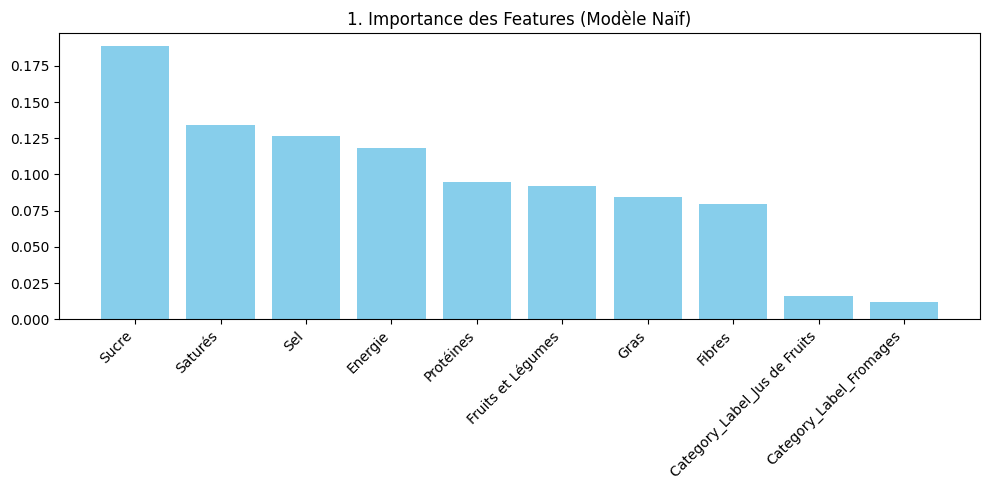

In [10]:
from food_analyzer.predictor import NutriModel
import matplotlib.pyplot as plt

# Initialisation
predictor = NutriModel(df_final)
scores_history = {} 

# =========================================================
# 1️⃣ TRAIN / TEST NORMAL (La Baseline)
# =========================================================
print("\n🟦 --- ÉTAPE 1 : BASELINE SIMPLE ---")
predictor.prepare_data(include_categorical=True)
predictor.train()
scores_history['1. Baseline'] = predictor.evaluate(method="simple")

# 📊 VUE 1 : Comment réfléchit le modèle "naïf" ?
predictor.plot_feature_importance(top_n=10, custom_title="1. Importance des Features (Modèle Naïf)")


🟨 --- ÉTAPE 2 : TUNING DU MODÈLE BASELINE ---
🔧 Optimisation en cours (Patience...)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
🎉 Meilleurs params : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📊 CV Score : 84.53% (+/- 0.43%)


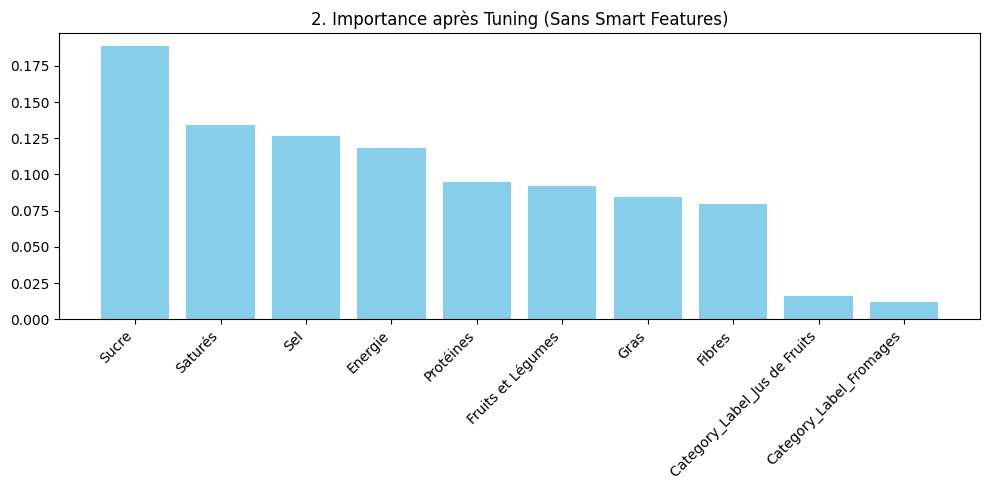

In [11]:
# =========================================================
# 2️⃣ HYPERPARAMÈTRES (Optimisation du modèle de base)
# =========================================================
print("\n🟨 --- ÉTAPE 2 : TUNING DU MODÈLE BASELINE ---")
predictor.optimize_hyperparameters()
scores_history['2. Baseline Tuned'] = predictor.evaluate(method="cross_val")

# 📊 VUE 2 : Est-ce que le tuning change la logique ?
predictor.plot_feature_importance(top_n=10, custom_title="2. Importance après Tuning (Sans Smart Features)")

🧬 Feature Engineering : L'approche par "Reverse Engineering"

Pour dépasser le plafond de performance des modèles classiques (~84%), nous avons enrichi le jeu de données en intégrant des connaissances métier (Domain Knowledge). L'algorithme du Nutriscore n'est pas aléatoire : il repose sur une formule mathématique précise (Points_Négatifs−Points_Positifs). Au lieu de laisser le modèle "deviner" cette logique complexe uniquement à partir des valeurs brutes, nous avons créé des "Smart Features" qui simulent le calcul officiel :

Contextualisation (Ratios) : Les variables Ratio_Sucre_Energie et Ratio_Gras_Energie permettent au modèle de comprendre la densité nutritionnelle. 10g de sucre n'ont pas le même impact dans un biscuit hypercalorique que dans une boisson où ils représentent 100% de l'apport énergétique.

Simulation des Points (N et P) : Nous avons approximé les composantes du score officiel via Est_Points_Negatifs (somme pondérée de l'énergie, graisses saturées, sucre, sel) et Est_Points_Positifs (fibres, protéines, fruits). Cela projette les nutriments bruts sur une échelle linéaire comparable à celle du Nutriscore.

Score Final Estimé : La variable Est_Score_Final calcule la différence brute entre ces deux composantes. Elle agit comme un "indice fort" pour le modèle, lui permettant de se concentrer sur la classification des cas limites (les produits frontières entre C et D) plutôt que de devoir réapprendre l'arithmétique de base.

Impact : Cette injection de logique métier transforme le problème : le modèle ne cherche plus seulement des corrélations, il apprend à corriger et affiner une formule qu'on lui a partiellement mâchée.


🟩 --- ÉTAPE 3 : AJOUT DES SMART FEATURES ---
🧠 Injection des connaissances humaines (Smart Features)...
✅ Colonnes calculées ajoutées !
😎 Mode EXPERT : 5 smart features détectées.
✅ Dataset prêt : 21 variables en entrée.
📊 CV Score : 86.96% (+/- 1.26%)


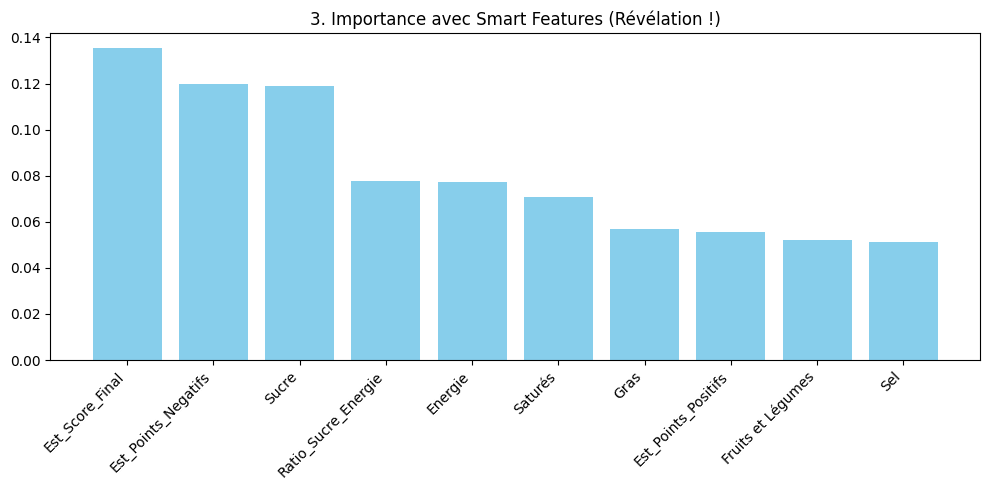

In [12]:
# =========================================================
# 3️⃣ FEATURE ENGINEERING (Le Game Changer)
# =========================================================
print("\n🟩 --- ÉTAPE 3 : AJOUT DES SMART FEATURES ---")
# 1. On injecte les calculs
predictor.add_smart_features()

# 2. On RE-PRÉPARE les données
predictor.prepare_data(include_categorical=True)

# 3. On RE-ENTRAÎNE
predictor.train() 
scores_history['3. Smart Features'] = predictor.evaluate(method="cross_val")

# 📊 VUE 3 : Le modèle a-t-il compris la formule ? (Regarde 'Est_Score_Final')
predictor.plot_feature_importance(top_n=10, custom_title="3. Importance avec Smart Features (Révélation !)")


🟧 --- ÉTAPE 4 : TUNING FINAL (SMART) ---
🔧 Optimisation en cours (Patience...)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
🎉 Meilleurs params : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📊 CV Score : 86.96% (+/- 1.26%)


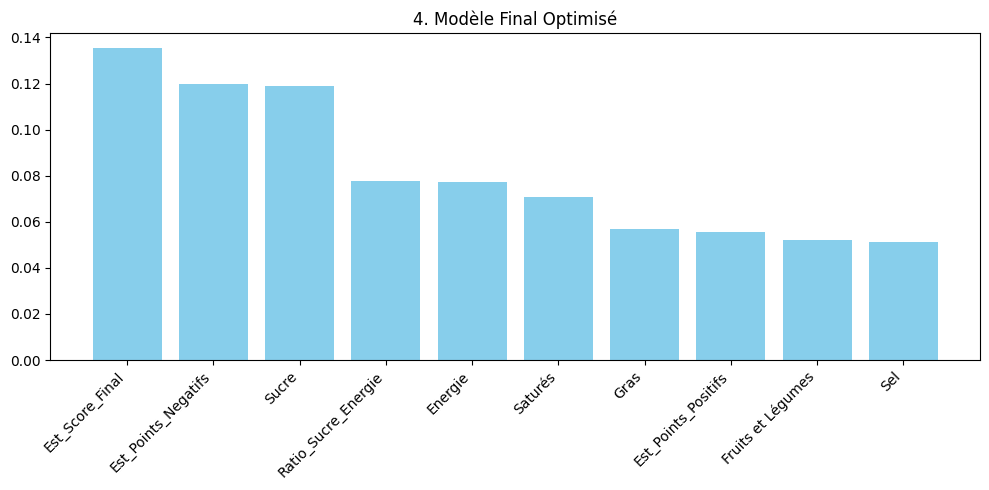

In [13]:
# =========================================================
# 4️⃣ HYPERPARAMÈTRES FINAL (Optimisation du modèle Smart)
# =========================================================
print("\n🟧 --- ÉTAPE 4 : TUNING FINAL (SMART) ---")
predictor.optimize_hyperparameters()
scores_history['4. Smart Tuned'] = predictor.evaluate(method="cross_val")

# 📊 VUE 4 : Le modèle ultime
predictor.plot_feature_importance(top_n=10, custom_title="4. Modèle Final Optimisé")


             RÉSULTATS FINAUX             


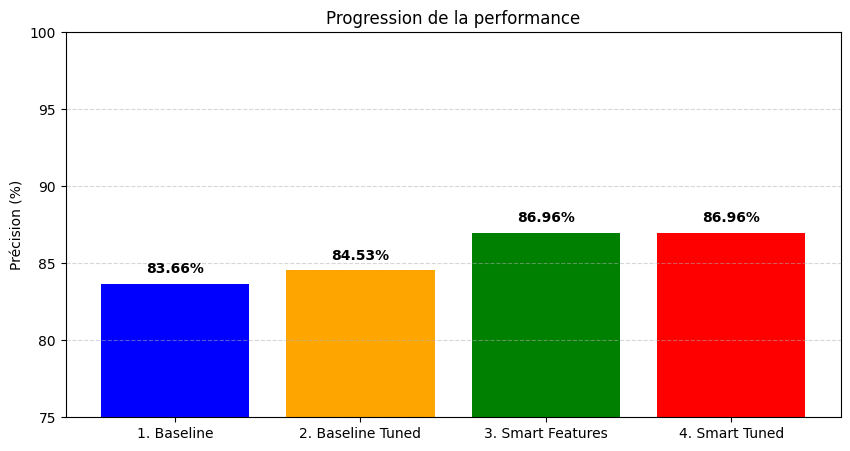

In [14]:
# =========================================================
# 🏆 BILAN FINAL
# =========================================================
print("\n" + "="*40)
print("             RÉSULTATS FINAUX             ")
print("="*40)

plt.figure(figsize=(10, 5))
bars = plt.bar(scores_history.keys(), [s*100 for s in scores_history.values()], 
               color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Précision (%)')
plt.title('Progression de la performance')
plt.ylim(75, 100) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
             f"{height:.2f}%", ha='center', va='bottom', fontweight='bold')
plt.show()